### Initial Setup

Installations, imports, helper functions

In [ ]:
# installs
%%capture

!pip install openai
!pip install transformers
!pip install sentence-transformers

In [ ]:
# imports
import numpy as np
import pandas as pd
import time
import torch
import tqdm
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt')

import openai
import os
openai.api_key = ""
# os.getenv("OPENAI_API_KEY")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Helper functions

def raw_predict(prompt, model = 'text-davinci-002'):
    response = openai.Completion.create(
            model= model, #"text-davinci-002",
            prompt=prompt,
            temperature=0.6,
            max_tokens = 200
        )
    result = response.choices[0].text
    return result

device = torch.device('cuda')

# sentence transformer to compute accuracy between predictions.
sbert_large = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device = device)
def cosine_sim(trues, preds):
    # example:
    # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
    embeddings_trues = sbert_large.encode(trues)#.cpu()
    embeddings_preds = sbert_large.encode(preds)#.cpu()
    cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
    return cosine_scores

# def cosine_sim(trues, preds):
#     sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#     # example:
#     # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
#     embeddings_trues = sbert.encode(trues)
#     embeddings_preds = sbert.encode(preds)
#     cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
#     return cosine_scores

sbert_small = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device = device) #all-mpnet-base-v2
def cluster(examples, threshold = 0.9, min_cluster_size = 5):
    embeddings = sbert_small.encode(examples, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
    clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
    return clusters, embeddings

# def cluster(examples, threshold = 0.9, min_cluster_size = 5):
#     sbert = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #all-mpnet-base-v2
#     embeddings = sbert.encode(examples, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
#     clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
#     return clusters, embeddings

In [ ]:
# Mount drive to pull the data folder.
from google.colab import drive
drive.mount('/content/drive')
prefix = '/content/drive/MyDrive/fsl-sequential-data-folder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.Series(open(prefix + '/virtual_home_train_prompt.txt').readlines())
val_data = pd.Series(open(prefix + '/virtual_home_validation_prompt.txt').readlines())
test_data = pd.Series(open(prefix + '/virtual_home_test_prompt.txt').readlines())

In [ ]:
train_data = pd.Series(open(prefix + '/FGR2R_train_prompt.txt').readlines())
val_data = pd.Series(open(prefix + '/FGR2R_validation_prompt.txt').readlines())
test_data = pd.Series(open(prefix + '/FGR2R_test_prompt.txt').readlines())
print(f'Total Data points: TRAIN {len(train_data)} | EVAL {len(val_data)} | TEST {len(test_data)}')

Total Data points: TRAIN 4675 | EVAL 340 | TEST 1391


# Experiments

## 1. GPT-3 Zero-Shot

In [ ]:
preds = []
trues = []

for index in tqdm.tqdm(range(len(test_data)), total = len(test_data)):
  if index == 100: break # index = 0
  separator = '=>'
  splits = test_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])
    prompt = f'''Given some activities from the Visual and Language navigation dataset, predict what will be the next activity.

    {query}=>'''

    result = raw_predict(prompt)
    pred = result.strip().split('\n')[0].split('=>')[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    # time.sleep(4)

  0%|          | 1/1391 [00:00<14:33,  1.59it/s]

walk to the left of the rail down the hall=>turn right at the end of the hall



  0%|          | 2/1391 [00:01<22:00,  1.05it/s]

Enter the kitchen=>Open the fridge



  7%|▋         | 100/1391 [01:48<23:18,  1.08s/it]


### Calculate accuracy

In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.6
acc = correct.sum() / len(res)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

print("Accuracy is: {:.2f}%".format(acc * 100))
print("Average Cosine Similarity is: {:.2f}%".format(df['Cosine Sim'].mean() * 100))
df

Accuracy is: 18.00%
Average Cosine Similarity is: 44.00%


,Actual,Predicted,Cosine Sim,Correct/not
0,walk down the hallway with the black rail,turn right at the end of the hall,0.706915,True
1,when you leave the sitting area and be face th...,Open the fridge,0.313965,False
2,go towards the black and white abstract painti...,take the escalator on the left,0.461638,False
3,Enter the bedroom then,going down the stairs,0.300645,False
4,walk down the hallway past the sofa,turn right at the end of the corridor,0.651014,True
...,...,...,...,...
95,walk down the hall,turn right into the bedroom,0.460552,False
96,head down the long hallway with the wine rack ...,look at the map on the wall,0.413199,False
97,walk through the open door into the hallway ne...,look around the room,0.395132,False
98,please get out from bed room,Look at the door,0.388965,False


## 2. GPT-3 with random support sets

In [ ]:
def generate_randomized_support_set(printf = False):
  indices = np.random.choice(list(range(len(train_data))), size = 10)
  support_set = train_data.iloc[indices]
  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set.iloc[i])
  return support_set

support_set = generate_randomized_support_set(printf = True)

walk up the step and in the front door of the building=>walk inside and go straight across to the room past the stair case=>walk up the circular shape stair and past the doormat

walk in the direction of the couch=>walk forward past the fireplace and around the back of the couch=>go to the left

walk past the ottoman on the left=>go straight and turn right=>walk towards staircase

exit the bedroom through the door=>exit to your right=>exit the bedroom through the door on the right of the television

facing a shower curtain turn around until you face a open door with a sink to the left=>exit bathroom to exercise room walk across exercise room to mirror=>leave the bathroom

turn right and go down the hall to the right=>turn around and go to the other side of the table=>walk towards dining room table



In [ ]:
preds = []
trues = []

for index in tqdm.tqdm(range(len(test_data)), total = len(test_data)):
  if index == 100: break # index = 0
  separator = '=>'
  splits = test_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])

    support_set = generate_randomized_support_set()

    prompt = f'''Given below are example sequences of elemental activities that can be performed by a robot.
    
    {''.join(support_set)}

    Now use the above data to predict what the robot might do next.
    {separator.join([text for text in splits[:time_step]])}=>'''

    result = raw_predict(prompt)
    pred = result.strip().split('\n')[0].split('=>')[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    # time.sleep(4)

  0%|          | 1/1391 [00:00<11:43,  1.97it/s]

walk to the left of the rail down the hall=>exit the house



  0%|          | 2/1391 [00:01<16:16,  1.42it/s]

Enter the kitchen=>turn right and walk through the door into the kitchen



  7%|▋         | 100/1391 [01:47<23:08,  1.08s/it]


### Calculate accuracy

In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.6
acc = correct.sum() / len(res)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

print(f'Accuracy is: {acc * 100}%')
print(f'Cosine Similarity is: {df["Cosine Sim"].mean()}')
df

Accuracy is: 34.0%
Cosine Similarity is: 0.538913905620575


,Actual,Predicted,Cosine Sim,Correct/not
0,walk down the hallway with the black rail,exit the house,0.416909,False
1,when you leave the sitting area and be face th...,turn right and walk through the door into the ...,0.603966,True
2,go towards the black and white abstract painti...,exit the room,0.344571,False
3,Enter the bedroom then,go down the hall,0.527063,False
4,walk down the hallway past the sofa,exit the room through the door on the right,0.677587,True
...,...,...,...,...
95,walk down the hall,go through the door at the end of the hall,0.672226,True
96,head down the long hallway with the wine rack ...,exit the room,0.476157,False
97,walk through the open door into the hallway ne...,turn around and walk out the door,0.497821,False
98,please get out from bed room,turn right and walk through the door into the ...,0.415297,False


## 3. GPT-3 Support Set Max Variance

### 3.1. Unsupervised Clustering for Support set selection

Generate clusters by transforming the train data into embeddings and grouping them by cosine similarity within 0.8.

In [ ]:
clusters, embeddings = cluster(train_data, min_cluster_size = 50, threshold = 0.80)
centroids = torch.stack([torch.mean(embeddings[cluster], axis = 0) for cluster in clusters])
len(clusters), len(train_data)

(14, 4675)

#### 3.1.1. Visualization of the formed clusters

1. By PCA

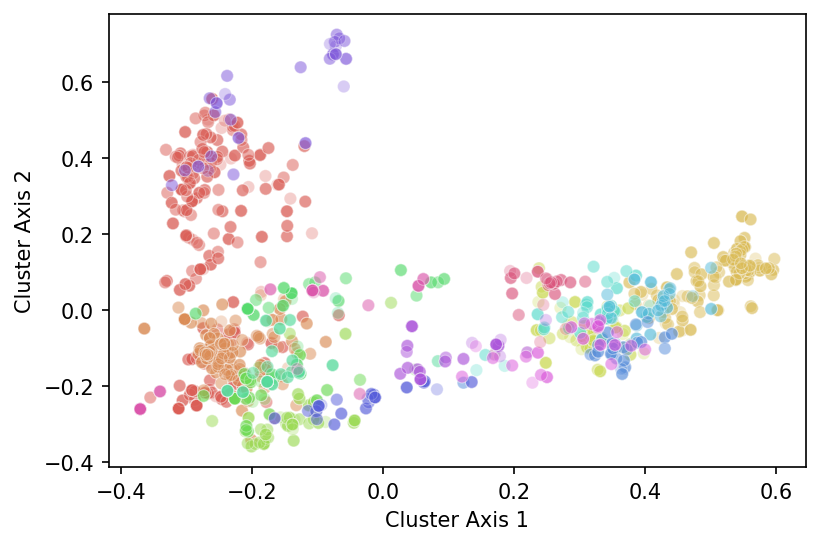

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

y = []
feats = []
for index, cluster in enumerate(clusters):
  y.extend([index] * len(cluster))
  feats.extend(embeddings[cluster].tolist())  

pca_result = pca.fit_transform(feats)

df = pd.DataFrame({
    'Cluster Axis 1': pca_result[:, 0],
    'Cluster Axis 2': pca_result[:, 1],
    'y': y
})

plt.figure(dpi = 150) # figsize=(16,10), 
sns.scatterplot(
    x="Cluster Axis 1", y="Cluster Axis 2",
    hue="y",
    palette=sns.color_palette("hls", len(clusters)),
    data=df,
    legend= False,#"full",
    alpha=0.3
)

2. By TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


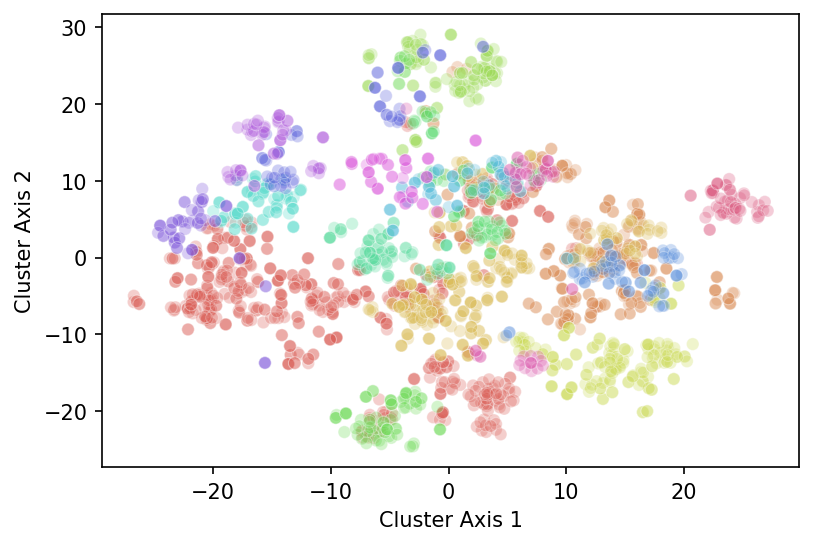

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

y = []
feats = []
for index, cluster in enumerate(clusters):
  y.extend([index] * len(cluster))
  feats.extend(embeddings[cluster].tolist())  

tsne_result = tsne.fit_transform(feats)

df = pd.DataFrame({
    'Cluster Axis 1': tsne_result[:, 0],
    'Cluster Axis 2': tsne_result[:, 1],
    'y': y
})

plt.figure(dpi = 150) # figsize=(16,10), 
sns.scatterplot(
    x="Cluster Axis 1", y="Cluster Axis 2",
    hue="y",
    palette=sns.color_palette("hls", len(clusters)),
    data=df,
    legend= False,#"full",
    alpha=0.3
)

### 3.2. Histogram plot of lengths of support sets.

In [ ]:
def generate_support_set(printf = False):
  support_set = []
  for cluster in clusters:
      indices = np.random.choice(cluster, size = 1)
      support_set.extend(train_data[indices])
  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

support_set = generate_support_set(printf = True)

Walk to home office=>Walk to coffee table=>Find coffee table=>Turn to coffee table=>Look at coffee table=>Find remote control=>Grab remote control=>Find television=>Turn to television=>Point at television=>Put back remote control

Walk to home office=>Walk to computer=>Find computer=>Switch on computer

Walk to dining room=>Walk to faucet=>Switch on faucet=>Find water=>Find drinking glass=>Grab drinking glass=>Find sink=>Put drinking glass on sink=>Grab drinking glass=>Switch off faucet=>Drink drinking glass

Walk to dining room=>Walk to freezer=>Find freezer=>Open freezer=>Find food food=>Grab food food=>Put food food in freezer=>Close freezer

Run to home office=>Walk to novel=>Find novel=>Grab novel=>Walk to couch=>Sit on couch=>Turn to novel=>Look at novel=>Find bookmark=>Grab bookmark=>Drop bookmark=>Turn to novel=>Look at novel=>Read novel=>Read novel=>Read novel

Walk to home office=>Walk to cat=>Find cat=>Walk to cat=>Touch cat



  0%|          | 1/1018 [00:00<01:32, 11.01it/s]
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Length of prompts')

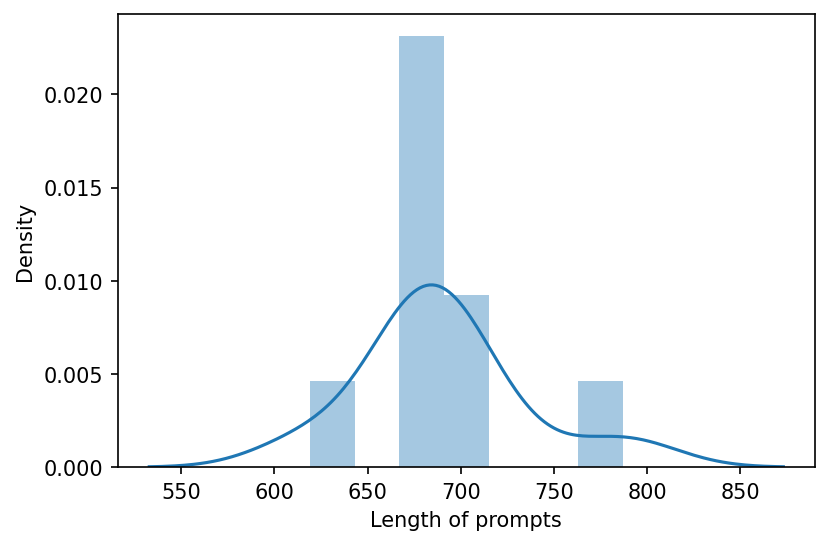

In [ ]:
prompt_lengths= []
for index in tqdm.tqdm(range(len(test_data)), total = len(test_data)):
  if index == 1: break # index = 0
  separator = '=>'
  splits = test_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])

    support_set = generate_support_set()

    prompt_text = f'''Given below are example sequences of elemental activities that can be performed by a robot.
    
    {''.join(support_set)}

    Now use the above data to predict what the robot might do next.
    {separator.join([text for text in splits[:time_step]])}=>'''
    
    tokens = nltk.word_tokenize(prompt_text)

    prompt_lengths.append(len(tokens))

doc_lengths = np.array(prompt_lengths)

plt.figure(dpi = 150)
sns.distplot(doc_lengths)
plt.xlabel('Length of prompts')

### Prompting to predict next activity

In [ ]:
preds = []
trues = []

for index in tqdm.tqdm(range(len(test_data)), total = len(test_data)):
  if index == 100: break # index = 0
  separator = '=>'
  splits = test_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])

    support_set = generate_support_set()

    prompt = f'''Given below are example sequences of elemental activities that can be performed by a robot.
    
    {''.join(support_set)}

    Now use the above data to predict what the robot might do next.
    {separator.join([text for text in splits[:time_step]])}=>'''

    result = raw_predict(prompt)
    pred = result.strip().split('\n')[0].split('=>')[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    # time.sleep(4)

  0%|          | 1/1391 [00:00<13:12,  1.75it/s]

walk to the left of the rail down the hall=>exit the bathroom



  0%|          | 2/1391 [00:01<24:04,  1.04s/it]

Enter the kitchen=>turn to your left



  7%|▋         | 100/1391 [01:52<24:09,  1.12s/it]


### Calculate accuracy

In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.6
acc = correct.sum() / len(res)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

print(f'Accuracy is: {acc * 100}%')
print(f'Cosine Similarity is: {df["Cosine Sim"].mean()}')
df

Accuracy is: 42.0%
Cosine Similarity is: 0.5506463050842285


,Actual,Predicted,Cosine Sim,Correct/not
0,walk down the hallway with the black rail,exit the bathroom,0.466316,False
1,when you leave the sitting area and be face th...,turn to your left,0.600128,True
2,go towards the black and white abstract painti...,turn right and walk through the door,0.518770,False
3,Enter the bedroom then,turn left and walk through the door into the l...,0.509934,False
4,walk down the hallway past the sofa,turn right,0.343862,False
...,...,...,...,...
95,walk down the hall,exit the room through the door on the other side,0.599939,False
96,head down the long hallway with the wine rack ...,turn right at the end of the hallway,0.757031,True
97,walk through the open door into the hallway ne...,turn around and walk into the next room,0.692437,True
98,please get out from bed room,exit the bedroom,0.642015,True


## 3. GPT-3 with similar examples in the support and query sets

In [ ]:
def generate_similar_support_set(query, clusters, centroids, n_examples = 15, printf = False):
  embeddings = sbert_small.encode(query, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
  
  pick_cluster = torch.argmax(torch.tensordot(centroids, embeddings.unsqueeze(dim = 1), dims = 1).squeeze(), axis = 0).item()

  indices = np.random.choice(clusters[pick_cluster], size = n_examples)
  support_set = train_data.iloc[indices].tolist()
  
  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

query = "Walk to home office=>Walk to desk=>Find chair=>Pull chair=>Sit on chair=>Find computer=>Switch on computer=>Find mouse=>Grab mouse=>Find keyboard=>Type on keyboard"
support_set = generate_similar_support_set(query, clusters, centroids, printf = True)

walk past the staircase=>go straight toward the couch=>turn around and walk straight forward towards the tv room

walk in the direction of the couch=>walk forward past the fireplace and around the back of the couch=>go to the left

walk behind couch towards the fireplace=>pass the fireplace=>walk behind couch and turn left

pass between couch and stair continue into=>turn to the left all around=>walk through the living room

walk through the room behind the couch=>go straight past the couch till you be at the double door=>walk straight to the edge of the open door

walk in the direction of the couch=>walk forward past the fireplace and around the back of the couch=>go to the left



In [ ]:
preds = []
trues = []

for index in tqdm.tqdm(range(len(test_data)), total = len(test_data)):
  if index == 100: break # index = 0
  separator = '=>'
  splits = test_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])

    support_set = generate_support_set(query)

    prompt = f'''Given below are example sequences of elemental activities that can be performed by a robot.
    
    {''.join(support_set)}

    Now use the above data to predict what the robot might do next.
    {separator.join([text for text in splits[:time_step]])}=>'''

    result = raw_predict(prompt)
    pred = result.strip().split('\n')[0].split('=>')[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    # time.sleep(4)

  0%|          | 0/1391 [00:00<?, ?it/s]

go down the stair=>go down the stair then stop=>go all the way down the stair then wait

turn around and walk out of the room=>exit the bedroom=>exit bedroom pass stair

turn to your left=>exit the bathroom then=>walk away from bathroom straight past bed turn

leave the kitchen=>turn around and walk into the room on the left=>take a left

walk down hallway to right=>walk through the hallway pass the window to outside=>walk straight down the hallway

go across the room with the banquet table=>wait at the last doorway on the right=>go straight and pass all the chair then turn right



  0%|          | 1/1391 [00:01<28:44,  1.24s/it]

walk to the left of the rail down the hall=>exit the room

walk up the stair=>walk up stair=>walk towards the stair

walk straight down the hallway=>walk across the bedroom with the bed on your right as you pass it=>walk through the bedroom and down the hall

exit the bathroom use the door on the far left=>exit the bathroom=>exit the bathroom

turn right and walk through the kitchen=>turn around and face the kitchen island=>turn right until you face the kitchen island

walk around the dining room table to your right past the stair into the bathroom on your left=>walk towards the spiral stair=>exit the dining room

walk past the chair=>walk forward in the direction of the dining table=>leave the sitting area



  0%|          | 2/1391 [00:02<25:07,  1.09s/it]

Enter the kitchen=>turn around and face the kitchen island

go up the stair=>go up the stair=>walk up

turn around and exit the bedroom into the hallway=>leave the bedroom=>exit the bedroom

walk past the foot of the bed towards the bathroom=>turn right after the brown chair=>exit bedroom to hall

walk through the kitchen past the dining room table and chair=>walk straight behind the counter to the first doorway on your right=>walk to the last bar chair on the left

turn to the left=>go through the door that lead to the stair=>walk toward the room with brown wood furniture

go and start up the step=>walk into the dining room and right past the dining room table and chair=>walk toward the glass table and chair



  0%|          | 3/1391 [00:03<22:12,  1.04it/s]

go up the stair=>go up the stair and through the door=>continue up the stair when you get to a large table with chair turn

exit the room into the corridor=>walk through the bathroom door=>exit the room you be in

leave the bathroom through the door on the right=>exit room with toilet=>exit the portion of the bathroom with the toilet through the open door

turn right and walk across the room past the stair=>walk straight past the table and chair=>walk forward toward the dining table

walk down hallway to right=>walk through the hallway pass the window to outside=>walk straight down the hallway

face dining table=>turn left and go past the table and chair=>turn left and walk across the room



  0%|          | 4/1391 [00:04<24:02,  1.04s/it]

walk up the stair to the right=>take a walk up these stair=>walk up the stair to the top

turn and walk through the door that lead to the hall=>leave the bedroom=>enter the hallway

leave the bathroom=>exit the shower=>walk to the right side of the bathroom

walk into the kitchen=>go to the right to enter the kitchen=>turn around and walk past the kitchen island

go towards the stair pass the=>walk forward until you have reach stair on your left=>exit the living room walk past the dining

walk straight and then turn left=>walk past the round table and chair=>walk to the stair



  0%|          | 5/1391 [00:05<24:13,  1.05s/it]

turn around and head up the stair to the top=>climb the wooden stair lead upwards=>walk up the stair

leave the bedroom=>turn around and walk into the dining room on the left=>keep walk forward towards the staircase on the right

exit the room=>turn around and exit the room=>turn around and exit the room

go straight and turn left pass the table=>walk past kitchen on the right=>walk straight through the doorway that be in front of you

exit the bedroom=>turn right and walk through door=>walk down the hallway pass by the stairwell and bathroom

turn around until you can see the dining room with the mirror in the corner=>walk down the stair=>walk downstairs and wait in the dining room at the top of the step



  0%|          | 6/1391 [00:05<21:43,  1.06it/s]

go up the stair=>continue up stair at top of stair turn=>walk up the stair continue

turn towards your right=>walk int bedroom=>walk straight into the room and turn right

leave the room=>exit the room=>exit the room

walk towards dining table=>go through the kitchen and toward the dining table=>go through the kitchen

walk through the hallway=>turn right and walk towards the chair in the corner of the hallway=>exit the room

turn right and go down the hall to the right=>turn around and go to the other side of the table=>walk towards dining room table



  1%|          | 7/1391 [00:06<20:48,  1.11it/s]

head up the stair turn=>walk up the step=>go up the stair

exit the bedroom where you start by the middle door=>exit room through door=>exit the bedroom

exit the bathroom by go straight=>go down the hall=>exit the bathroom

turn around and walk to the right side of the room=>exit the dining parlor=>walk through the sitting room

go down the hallway to the right=>exit the bedroom=>walk right past the stair

walk all the way across the room=>walk between the couch and the dining room table and chair=>go away from the stair towards the large window walk between the couch and the dining table



  1%|          | 8/1391 [00:07<20:47,  1.11it/s]

walk down out the door=>turn left to go through the door and down the stair=>walk to the top of the stair

walk out of the room=>exit bedroom=>head forward past the bed

exit the bathroom to the room=>exit the bathroom=>exit the bathroom

exit the kitchen=>go around the bar to exit out the doorway straight ahead=>leave the kitchen

walk down the stair and straight into the dining room across from the stair=>go down the stair=>go down the stair and straight into the dining room

exit the dining room to the right=>exit the dining room=>go straight past all the table and chair



  1%|          | 9/1391 [00:08<19:30,  1.18it/s]

walk up the stair=>walk up the stair=>finish go up the stair

turn left and exit the room=>exit the room=>turn left and exit the bathroom

walk out of the closet and through the bathroom=>turn to the right=>exit the bathroom

go into the kitchen and through the doorway on the left=>enter the kitchen=>turn around so you be face the kitchen

turn right walk to the stair=>exit the room=>cross the room

go upstairs and wait near the top=>walk through the dining room to the stair=>go past the clear table and chair



  1%|          | 10/1391 [00:08<17:23,  1.32it/s]

go down the walk=>start at the stair landing=>go forward and go up the stair to the top

turn left and exit the room=>exit the bathroom=>exit bedroom

exit the bathroom=>turn to the right=>exit the bathroom

exit the kitchen=>exit the kitchen=>start walk towards the living room

go left in the hallway=>go pass the chair and to the left=>after you leave the sitting area you need to make a left in the hallway and walk to the stair

head inside and cross the room towards the stair=>head straight and to the left of the table=>walk across large hall



  1%|          | 11/1391 [00:10<20:03,  1.15it/s]

walk down the ramp=>walk down the staircase=>walk towards the stair

exit the bedroom=>turn and walk through the bedroom pass the=>turn around and walk to the door

exit the bathroom=>exit bathroom=>leave the bathroom

walk forward to the kitchen=>walk past the stair and towards the kitchen=>go pass the stair on the left

go past the wardrobe style door down the path to the stair=>enter through the doorway with the white marble floor=>exit to the left

walk past the glass dining table=>walk forward towards the stair=>leave the living room



  1%|          | 12/1391 [00:11<22:07,  1.04it/s]

go up the stair=>proceed up the stair curve right=>walk up stair

go straight through the doorway=>exit the bedroom=>exit the bedroom

go out the bathroom door=>leave the bathroom=>turn right

walk past the stair on your right=>walk across room to kitchen=>walk forward pass the staircase and the glass dining table

exit the room use the door on the right=>exit the bedroom=>walk out of the room and around the landing towards the stair

go to the right of the table=>exit the dining room into the foyer=>walk straight ahead to the other end of the table



  1%|          | 13/1391 [00:12<27:10,  1.18s/it]

go to the top of the staircase=>go up the stair=>walk up the stair

go through the door opposite the bathroom=>walk into the bedroom and into the hallway=>walk into the bedroom

exit the bathroom=>go through the door on the right and turn right=>exit the bathroom use the door on the right then turn right

turn right and walk behind the long sectional=>walk out of the kitchen=>exit the kitchen

at the top of the stair take a left until you see a small set of stair to your left=>walk into larch archway go=>walk towards the hall past the staircase

walk past the glass dining table=>walk forward towards the stair=>leave the living room



  1%|          | 14/1391 [00:14<30:32,  1.33s/it]

go past the top of the stair=>walk past the stair in front of you=>take a left out of the doorway

enter the bedroom through the doorway=>leave the bathroom=>walk straight ahead and into the bedroom

exit the bathroom=>go left and then through the hallway and out the door=>leave the bathroom

turn right and go into the room turn=>turn around=>go down the hall and into a dining area

turn right walk to the stair=>exit the room=>cross the room

walk all the way across the room=>walk between the couch and the dining room table and chair=>go away from the stair towards the large window walk between the couch and the dining table



  1%|          | 15/1391 [00:15<27:15,  1.19s/it]

walk down the stair=>turn to your right=>turn and walk down the flight of stair

exit the closet toward the bed=>exit the bedroom=>go forward

go around the bed=>exit the bathroom=>leave the bathroom area

turn right and walk through the kitchen then=>turn right and pass the dining table=>turn right and walk past the cabinet and desk area

head up the step to the left of the screen=>exit the room by go up the three step=>turn around and go up all the stair behind you

walk toward the table and chair=>go pass the stair to your left=>walk past the stair



  1%|          | 16/1391 [00:16<23:57,  1.05s/it]

go straight ahead and enter the hallway=>walk past the stair=>go straight through the corridor with the stair on the left

walk down the hallway=>take a right through the first door into the bedroom=>go straight in the hallway

exit the bathroom to the room=>leave the bathroom=>leave the room

turn around and walk all the way through the kitchen past all the bar stool=>turn left and walk through the kitchen=>turn left and walk down the hall past the kitchen

walk through the door to the stair=>with the slide glass door to your immediate right look ahead of your for the wall with two door on it=>walk into the room and through the second door on the right

go past the stair=>turn around and go across the floor pass the stair and the table=>walk past the staircase



  1%|          | 17/1391 [00:17<23:38,  1.03s/it]

turn right and go up the step=>exit the stairwell=>go down the stair and to the right

walk through door to the right of the double door closest walk through=>walk around the bed and into the bathroom through the third door on the left wall=>turn around and exit the bedroom via the rightmost door

exit the bathroom into the dining room=>exit bathroom walk left into dining room=>exit the bathroom

walk forward and out of the kitchen into the room with the pink dining chair=>walk through the pantry area=>turn right go down the hallway

walk down the flight of stair=>with the door to the bedroom behind you walk straight and then down the stair=>walk past the yellow painting on the wall and down the stair

walk forward and then turn right at the long table and chair=>take a right=>turn right at the top of the stair



  1%|▏         | 18/1391 [00:18<22:56,  1.00s/it]

turn left and enter the house=>turn left and walk down the stair then=>go down the stair

walk out of the bedroom=>exit the room use the door on the left=>walk through the bedroom past the bed

exit the bathroom=>leave bathroom=>walk forward out of the bathroom into the hallway

walk past the couch and across the room=>turn right to face the end of the yellow kitchen with a set of stair on the right and a table on the left=>walk straight away from the door to the outside past the kitchen on the left and stair on the right

turn right at the bottom of the stair=>go straight down the hallway until you get to a room=>turn left and enter the bedroom

go past the table and chair=>put the stair directly behind you=>walk straight away from the staircase



  1%|▏         | 19/1391 [00:19<27:32,  1.20s/it]

walk up the stair=>go straight up the stair=>walk up towards the stair with the close cabinet on your left

turn around and walk down the hallway=>with the bathroom to your right start walk down the hallway until you exit the door open at the end then=>go straight down the hallway

exit the bathroom to the room=>exit the bathroom=>exit the bathroom

walk past the couch and across the room=>turn right to face the end of the yellow kitchen with a set of stair on the right and a table on the left=>walk straight away from the door to the outside past the kitchen on the left and stair on the right

go to the bottom of the staircase in the dining room=>walk across the room past the stair=>step outside of the room

walk past the round table and chair=>turn around and walk straight pass the chair until you reach the stair on your right=>walk straight then turn right



  1%|▏         | 20/1391 [00:21<28:18,  1.24s/it]

go up the stair=>go upstairs down the hall=>ascend stair

walk out of the open door into the hallway=>turn to the right until you be facing a open door with a strip bed to the right and a mirror to the left=>exit bedroom

exit the bathroom=>leave the bathroom=>exit the bathroom

walk through the kitchen=>walk to the dining table=>walk from living room to the right into the kitchen

walk toward the staircase=>exit the intersection towards the staircase=>go to your right

pass the dining room table with chair then=>turn to the left walk to the=>walk past the dining table



  2%|▏         | 21/1391 [00:22<26:11,  1.15s/it]

go to the bottom of the stair=>go down the stair=>go downstairs

leave the bedroom=>turn around and walk into the dining room on the left=>keep walk forward towards the staircase on the right

exit the half bath=>exit the bathroom=>leave restroom into hallway

turn right and walk across the room past the stair=>walk straight past the table and chair=>walk forward toward the dining table

from the top of the stair make a right=>walk down hall toward bedroom=>go down the hall to the right at the top of the stair

walk past the chair=>walk forward in the direction of the dining table=>leave the sitting area



  2%|▏         | 22/1391 [00:23<26:12,  1.15s/it]

go up the rest of the stair=>go up the stair=>turn and walk up the stair

exit bedroom to hallway=>walk past art gallery wall=>with the bed on your right walk forward down the hall in the hallway

walk out of the bathroom through the doorway=>take a right out of the bathroom=>exit the bathroom

walk towards the kitchen=>walk into the kitchen=>turn right walk across the dining table area room

exit the bedroom=>turn right and walk through door=>walk down the hallway pass by the stairwell and bathroom

walk along the wall next to the chair and desk=>walk to the other end of the room=>stay along the right side of the two round table



  2%|▏         | 23/1391 [00:23<22:58,  1.01s/it]

walk downstairs turn left=>walk down the stair=>go down the stair

go straight through the door=>exit bedroom to hallway turn=>leave the bedroom

leave the bathroom and bedroom=>exit the bathroom=>leave the bathroom

go into the dining area=>walk across the dining room=>walk into the dining room

continue up the stair=>turn around and walk into the next room=>walk straight ahead into the bedroom

walk across the room=>head towards the stair to go around the table on your right=>walk behind chair through hallway



  2%|▏         | 24/1391 [00:24<22:43,  1.00it/s]

walk up the stair=>go straight up the stair=>walk up towards the stair with the close cabinet on your left

after you leave the bedroom make a left in the hallway=>exit the bedroom=>go around the bed and to the door

exit the bathroom=>go through the doorway=>leave the bathroom

walk into the kitchen=>go to the right to enter the kitchen=>turn around and walk past the kitchen island

turn right and walk down the hall=>turn right and walk across the hall=>walk into the hallway

go and start up the step=>walk into the dining room and right past the dining room table and chair=>walk toward the glass table and chair



  2%|▏         | 25/1391 [00:26<23:56,  1.05s/it]

turn left and walk past the stair head down the hallway=>go past the stair on the right and down the hallway=>walk towards the staircase

go out the room=>exit the room=>exit bedroom

exit the room with the toilet=>exit the bathroom=>exit the bathroom then go forward

walk straight past the living room and head towards the stair=>walk forward through the dining room=>turn so your back be face the brown wooden table in the middle of the kitchen

turn right=>facing the stair lead upwards enter the room=>go inside then make a left u turn to go into the room at the end of the hallway

go straight until you pass the bar with the chair=>walk from the kitchen towards the staircase=>go right to the hall



  2%|▏         | 26/1391 [00:27<23:30,  1.03s/it]

turn left and enter the hallway then turn left=>go down the stair turn left=>go down three stair

head down the hallway=>turn towards the hallway=>exit bedroom to hallway

walk out of the bedroom=>exit the bathroom=>leave the bathroom

walk into the kitchen area=>walk into the kitchen=>from the dining room walk into the kitchen

turn around and exit the room=>walk from sitting room to stair=>turn around and walk through the living room then turn right

turn around move forward 4 step stop=>walk past the glass dining table=>turn around and walk straight



  2%|▏         | 27/1391 [00:28<24:28,  1.08s/it]

go up the two step on your left=>walk up the step and down the hall past the stair=>go up the stair

exit the room=>walk across the hall and through the bedroom=>walk forward through the closest doorway

leave the bathroom=>exit the bathroom=>exit the bathroom

walk past the kitchen and through the doorway on the left=>turn to the left=>turn around and walk past the dining area

turn right walk to the stair=>exit the room=>cross the room

walk down the stair=>go downstairs past the large dining table=>go down the stair



  2%|▏         | 28/1391 [00:30<35:39,  1.57s/it]

go up the stair then u=>continue up the step=>finish walk up the last few step

from bathroom enter bedroom=>enter bedroom=>go out the door to the right into the bedroom

exit the bathroom=>leave the bathroom=>exit the bathroom

walk left down the hall=>walk towards the picture on the wall=>walk past the dining room and down the hall

walk out of the bedroom and up the stair=>exit the room=>turn left and exit the bedroom walk past the

go up the stair=>go up the step then turn right and go straight past the round table after you pass the round table turn=>walk up stair



  2%|▏         | 29/1391 [00:31<31:45,  1.40s/it]

walk up the stair to the right=>take a walk up these stair=>walk up the stair to the top

turn around and exit the room though the doorway to the left=>turn around and take a left=>leave the bedroom

exit the bathroom=>turn to your left=>while face toilet turn left

turn right around the counter=>walk out of the kitchen=>turn right go straight to the end of room take

walk down the hallway to the left there will=>walk down hallway=>go down the hallway until you get near the exit sign

walk behind the chair and past the end table in the hallway=>walk right towards the open corner=>exit through the doorway on the right



  2%|▏         | 30/1391 [00:33<30:10,  1.33s/it]

turn right up the stair to the first landing=>go upstairs down the hallway on the left=>go up the stair

exit the room=>pass the picture with the lady and throught door to your right up the stair and past some wood shelf=>walk out of the room into the hallway

leave the room=>leave the bedroom=>exit bathroom

walk forward into the dining room=>walk between the two table=>go around the table to your immediate left head to the doorway at the left of the room

walk out of the bedroom and up the stair=>exit the room=>turn left and exit the bedroom walk past the

pass the dining room table with chair then=>turn to the left walk to the=>walk past the dining table



  2%|▏         | 31/1391 [00:33<25:57,  1.15s/it]

head to the left doorway=>go up the stair=>walk up the step and past the chair through the entryway on the left

walk through the open door=>pass the bed=>exit the room

leave the bathroom=>follow the hall to the living area=>leave the bathroom

walk in the direction of the dining room=>walk toward the deck=>exit the kitchen area

walk out of the bedroom and up the stair=>exit the room=>turn left and exit the bedroom walk past the

turn around and exit into the room with the large table=>head out through the dining room and into the=>turn around go left across the room



  2%|▏         | 32/1391 [00:34<23:05,  1.02s/it]

walk to the top of the stair=>go up the stair=>go up the stair

exit the room=>pass the picture with the lady and throught door to your right up the stair and past some wood shelf=>walk out of the room into the hallway

walk through bathroom doorway=>exit the bathroom=>leave the bathroom

walk across dining room to kitchen=>turn around and walk through the dining room then turn right=>walk forward pass the table

walk up the stair=>exit the bathroom area=>exit the room and turn left

walk across the room=>walk through the dining area past the table and couch=>go between the table and the couch and straight on



  2%|▏         | 33/1391 [00:35<23:13,  1.03s/it]

walk up the stair to right=>go up the stair=>walk up the spiral staircase

exit the bedroom and head straight down the hallway=>turn around and go pass the bed=>walk around the right of the bed

leave the bathroom=>exit the bathroom=>leave the bathroom and bedroom

walk past the kitchen and through the doorway on the left=>turn to the left=>turn around and walk past the dining area

walk across the room=>turn right and walk to the door on the right 2nd closest to the stair=>go straight and go into the fourth door from the right

walk all the way across the room=>walk between the couch and the dining room table and chair=>go away from the stair towards the large window walk between the couch and the dining table



  2%|▏         | 34/1391 [00:37<26:21,  1.17s/it]

walk down staircase=>walk down the stair=>turn around and go down the staircase

exit bedroom=>walk out of the bedroom and past the rail=>turn left until you be face the closet

leave the room=>take a left=>walk out the door into the hall turn

enter the dining room area=>walk through the door into the dining room area=>walk forward out the door

walk into the hallway and to the right=>enter the hallway=>walk down the hallway to your right then turn left

go to the right of the table=>exit the dining room into the foyer=>walk straight ahead to the other end of the table



  3%|▎         | 35/1391 [00:37<24:26,  1.08s/it]

go down the stair=>go down the stair then stop=>go all the way down the stair then wait

turn around and turn left=>go down the hall=>leave the bedroom

leave the bathroom=>walk out into the room=>exit the bathroom

walk across dining room=>walk to the left of the dining room table and chair and toward the bookshelf=>go past the table and chair

turn around to walk down the hallway=>go straight down the hallway=>walk away from door to outside down the hallway

exit the dining room to the right=>exit the dining room=>go straight past all the table and chair



  3%|▎         | 36/1391 [00:38<20:56,  1.08it/s]

go down the stair to your right=>walk down the stair=>turn right and head down the stair

go through the bedroom exit through the door by the nightstand=>walk towards the bed=>exit the bathroom

turn to the right=>exit the bathroom=>exit the door

leave the dining area=>turn around and enter the kitchen area=>go past the table and chair

at the top of the stair take a left until you see a small set of stair to your left=>walk into larch archway go=>walk towards the hall past the staircase

walk to the opposite side of the dining area=>go straight until you pass many round table with chair=>turn around and walk to the middle of the dining room where it be open



  3%|▎         | 37/1391 [00:39<20:38,  1.09it/s]

walk straight into the room=>exit the stair=>stand at the top of the stair

go into the bedroom make=>exit the bathroom into the bedroom then turn right=>exit bathroom to bedroom

exit the bathroom=>exit the bathroom=>go past the toilet

walk through the door=>walk into the door in front of you=>walk forward into the dining room

face the staircase=>leave the bathroom=>turn left and go up to the top of the staircase

go straight=>turn around and enter the dining room=>walk through entryway into dining room with the beige chair and glass table



  3%|▎         | 38/1391 [00:40<19:01,  1.19it/s]

from the stair turn right=>walk through the hallway ahead=>walk past stair

with the window behind you go straight and out of the room into the hallway=>exit the room=>go through door turn

exit the bathroom=>turn left=>walk out of the bathroom

step forward turn left and enter the kitchen=>walk forward with three wooden chair on your left=>go past the three chair on the left

from the top of the stair make a right=>walk down hall toward bedroom=>go down the hall to the right at the top of the stair

pass the table with chair and head toward the stair=>walk across the left side of the dining room=>go straight through the door



  3%|▎         | 39/1391 [00:41<20:17,  1.11it/s]

go through the door and turn right=>walk through the doorway=>go through the doorway

exit the closet toward the bed=>exit the bedroom=>go forward

turn left and go pass the=>walk out of the bathroom=>exit the bathroom

walk straight all the way across the room=>walk along the hallway with the glass window to the right=>walk straight and wait in between the dining room and the kitchen

turn around and turn left down the hallway=>turn left and go all the way down the hallway and into the room=>walk forward and turn left to enter the hallway

go across the room with the banquet table=>wait at the last doorway on the right=>go straight and pass all the chair then turn right



  3%|▎         | 40/1391 [00:42<22:14,  1.01it/s]

walk towards the stair and past the elevator on the right=>exit the hallway=>turn around and exit the door that lead to the stair and elevator

with the book on your left go down the stair and into the bedroom=>walk all the way down the stair=>turn around and walk down the stair and through the door

exit the bathroom=>go into the hallway=>exit the bathroom

go straight into the kitchen=>walk into the kitchen=>turn left and enter the kitchen

walk into the hallway=>walk downstairs turn right stop indoorway=>exit the room

turn around until you can see the dining room with the mirror in the corner=>walk down the stair=>walk downstairs and wait in the dining room at the top of the step



  3%|▎         | 41/1391 [00:43<20:58,  1.07it/s]

go straight and turn right=>go up the three step and to the right and up the small set of stair=>head up

exit the bedroom through the double door=>go out the door to your left=>walk into the hallway and towards the stair

head out of the bedroom=>exit the bedroom from the door nearby behind then turn right=>leave the bedroom

walk through the door=>walk into the door in front of you=>walk forward into the dining room

walk down the three step and into the bathroom on the left=>exit the room turn left=>walk down the stair

walk past the round table and chair=>turn around and walk straight pass the chair until you reach the stair on your right=>walk straight then turn right



  3%|▎         | 42/1391 [00:43<19:22,  1.16it/s]

walk all the way down the stair next to you=>go all the way down the stairway=>go down the stair

exit the room=>turn around and exit the bedroom=>exit through the door

exit the bathroom to the room=>exit the bathroom=>exit the bathroom

walk past the seating area=>go past the two chair to the kitchen=>turn around and walk towards the kitchen

walk into the room=>walk straight towards the staircase=>walk through the large open room with the round table in the middle

walk out of the bedroom=>go straight then turn right and head toward the glass dining room table with the fancy chair pass the=>turn right and enter hallway



  3%|▎         | 43/1391 [00:44<19:47,  1.14it/s]

start with the elevator to your back=>go past the stair through the doorway=>walk past the stair out of the room

walk through the door=>exit the bedroom=>exit bedroom

walk out of the closet and through the bathroom=>turn to the right=>exit the bathroom

walk into the kitchen=>walk around the island counter and into the open door=>walk past the basket and kitchen island

walk down hallway to right=>walk through the hallway pass the window to outside=>walk straight down the hallway

walk straight across the room past the long table=>go to the left side of the dining table=>go to the left side of the dining table



  3%|▎         | 44/1391 [00:45<19:11,  1.17it/s]

walk past the stair=>go straight pass the staircase on the left=>walk forward to the right side of the stair

exit the bathroom=>exit the bathroom toward the room=>leave the bathroom and bedroom

exit bedroom=>exit the bedroom=>exit the room

turn left and walk along the long table=>walk forward towards the door=>enter the dining area

go to the hallway left of the stair=>go down the hallway that be to the left of the stair=>walk forward and enter the bedroom on the left of the stair

put the dining table behind you=>go up the stair=>exit the room



  3%|▎         | 45/1391 [00:46<19:38,  1.14it/s]

go straight towards the front door=>go down the stair and go straight=>walk down the hallway opposite of the stair

leave the bedroom=>exit the bedroom door=>walk down the stair

exit the bathroom and turn left=>exit toilet=>turn right then exit to your left

go straight through the door=>walk through the door and past the dining room table and chair=>walk into the dining room

turn right and walk down the hall=>turn right and walk across the hall=>walk into the hallway

walk towards the round table with the two chair=>turn right and follow the path=>walk all the way forward pass everything



  3%|▎         | 46/1391 [00:47<20:56,  1.07it/s]

turn right go up the stair=>go all the way up the stair=>go up the stair

leave the bedroom=>turn right walk towards the stair=>turn right and exit the room

leave the bedroom=>exit the room=>exit the bedroom

go up the two step=>turn around and continue down the hall and turn right=>walk into the kitchen

walk down the stair and straight into the dining room across from the stair=>go down the stair=>go down the stair and straight into the dining room

walk to the left of the table and chair=>go straight through the room opposite the staircase=>turn around and walk all the way down past the dining table



  3%|▎         | 47/1391 [00:48<20:17,  1.10it/s]

go down to the bottom of the stair=>go all the way down the stair=>walk down the stair

turn around and exit the room though the doorway to the left=>turn around and take a left=>leave the bedroom

exit the laundry room=>exit the bathroom=>exit room

walk through the great room toward the kitchen=>walk forward and turn right=>walk to the kitchen on the right side of the room

turn around and exit the room=>walk from sitting room to stair=>turn around and walk through the living room then turn right

go up the stair=>go up the step then turn right and go straight past the round table after you pass the round table turn=>walk up stair



  3%|▎         | 48/1391 [00:49<22:12,  1.01it/s]

go up the stair=>walk up stair=>walk up stair

exit the room use the double door on the right=>leave the bedroom through the door at the foot of the bed to the right=>exit the bedroom

exit the bathroom=>exit the bathroom=>turn around and exit the bathroom

exit the kitchen=>turn to your left=>walk out of the kitchen area past the center counter top

leave this room=>go through the white hallway to the staircase=>walk down the hall toward the top of the stair

turn left and walk straight=>walk past the table with the screen on your right=>head towards the far end of the room



  4%|▎         | 49/1391 [00:50<22:00,  1.02it/s]

continue up the stair=>walk up the stair=>from the top of the stair go counter clockwise around the hallway

walk pass the foot of the bed and towards the open door on the other side of the room=>turn around and walk past the bed=>exit the bedroom through the door on the right wait in the kitchen on the right

leave the room=>exit the room=>exit the room

leave the dining area=>turn around and enter the kitchen area=>go past the table and chair

walk down the corridor toward the exit sign=>walk to the far end of the hall=>walk to the end of the hall and into the room on the left

move forward towards the step=>walk through the large room pass the table and couch area towards the small set of step on the other side=>walk up the stair



  4%|▎         | 50/1391 [00:51<23:06,  1.03s/it]

go up the stair=>head to the top of the colorful stair=>go up the stair

exit the bathroom toward the room=>leave the bathroom and bedroom=>walk left out of the bathroom and out of the bedroom

exit the room with the toilet=>exit the bathroom=>exit the bathroom then go forward

go straight past the kitchen=>turn around and take a left when you get to the kitchen area=>enter the house

walk into the room=>walk straight towards the staircase=>walk through the large open room with the round table in the middle

walk across the room=>head towards the stair to go around the table on your right=>walk behind chair through hallway



  4%|▎         | 51/1391 [00:52<22:45,  1.02s/it]

walk up stair=>walk away from front door up the stair on left on painting=>walk towards the stair

turn right and walk straight until you get to the last door on the left=>walk toward the office=>walk through the bedroom

exit the bedroom=>exit the bedroom=>exit the bedroom

turn around and walk all the way past the dining table=>walk past the dining room table and chair into the hallway=>walk through and out of the dining room

walk down the corridor toward the exit sign=>walk to the far end of the hall=>walk to the end of the hall and into the room on the left

walk straight across the room past the long table=>go to the left side of the dining table=>go to the left side of the dining table



  4%|▎         | 52/1391 [00:53<21:46,  1.03it/s]

go up the step=>walk up the stair and into the bedroom=>go up the stair

exit bedroom=>walk into the hallway=>exit the bedroom

walk into the bathroom area=>leave the room with the toilet=>exit toilet room

go past the main entrance=>turn around and go towards the hallway=>walk past the dining table and door to the kitchen into the hallway ahead

walk through the door to the stair=>with the slide glass door to your immediate right look ahead of your for the wall with two door on it=>walk into the room and through the second door on the right

walk past the chair=>walk forward in the direction of the dining table=>leave the sitting area



  4%|▍         | 53/1391 [00:55<26:52,  1.21s/it]

walk upstairs and wait on the landing=>walk to the top of stair=>turn to the right

exit bedroom to hallway=>turn left and go down the hall=>exit the bedroom

walk out of the blue wall bedroom and into the hallway=>exit the room then turn left=>leave the bedroom

turn to the right=>walk into the kitchen=>walk past the kitchen and into the hall to the left of the big mirror on the wall

go down the hallway to your right=>walk past the exit sign and down the hall=>go right down the hall

pass the table and chair=>go through the dining room and up the step=>go through the room towards the step



  4%|▍         | 54/1391 [00:56<24:43,  1.11s/it]

go up the stair=>continue up stair at top of stair turn=>walk up the stair continue

turn around and turn left=>go down the hall=>leave the bedroom

exit bedroom=>exit the room=>exit the bedroom

exit the kitchen=>walk rightward around the kitchen=>go in the kitchen and out the other door

exit the living area=>go up the stair on your right=>walk upstairs and wait at the top of the stairwell

walk past the glass dining table=>walk forward towards the stair=>leave the living room



  4%|▍         | 55/1391 [00:57<25:45,  1.16s/it]

turn right and go right toward the stair=>with the wall that do not have any door on your right exit through the doorway ahead of you=>turn to the right

walk parallel to the foot of the bed=>walk forward and then turn right=>exit the bedroom

leave the bathroom=>exit the bathroom=>leave the bathroom and bedroom

walk straight past the living room and head towards the stair=>walk forward through the dining room=>turn so your back be face the brown wooden table in the middle of the kitchen

go left in the hallway=>go pass the chair and to the left=>after you leave the sitting area you need to make a left in the hallway and walk to the stair

walk across the room=>head towards the stair to go around the table on your right=>walk behind chair through hallway



  4%|▍         | 56/1391 [00:58<23:19,  1.05s/it]

go around the staircase walk past the bar=>pass by the staircase ahead=>go around the front of the stair

exit the room and turn right=>exit bedroom turn right=>go to the door

exit the bathroom=>go through the door=>exit the restroom

go to your right=>go along the wall past the front door=>walk toward the kitchen at the hallway

walk through the door to the stair=>with the slide glass door to your immediate right look ahead of your for the wall with two door on it=>walk into the room and through the second door on the right

head to the left of the table and toward the stair=>walk to the left of the table=>head toward the stair



  4%|▍         | 57/1391 [00:59<22:09,  1.00it/s]

go past the stair and through the doorway=>move through the room with the marble staircase to your left=>turn until you see the staircase on your left

go straight through the doorway and in to the hallway turn=>walk out the first door on the left=>enter hall

leave the bedroom=>turn right to exit the bedroom=>facing the bed

turn right and walk across the kitchen area=>walk into the kitchen=>walk out of the closet into the kitchen

go to the bottom of the staircase in the dining room=>walk across the room past the stair=>step outside of the room

go straight until you pass the bar with the chair=>walk from the kitchen towards the staircase=>go right to the hall



  4%|▍         | 58/1391 [00:59<20:56,  1.06it/s]

go up the two step on your left=>walk up the step and down the hall past the stair=>go up the stair

go inside and take a left=>exit the bedroom=>walk through the door

leave the bedroom=>exit the room=>exit the bedroom

go straight through the door=>walk through the door and past the dining room table and chair=>walk into the dining room

go to the bottom of the staircase in the dining room=>walk across the room past the stair=>step outside of the room

walk forward through the banquet hall=>walk straight ahead and wait by the chair line up against the back wall=>walk straight across the dining room



  4%|▍         | 59/1391 [01:01<23:23,  1.05s/it]

take a left at the door=>walk towards the big black door=>go straight turn left to go up to the top of the staircase

exit the bedroom=>leave the bedroom=>walk around the bed a go out the bedroom door

exit bathroom to bedroom=>exit the bathroom=>exit the bathroom into the bedroom

turn around and walk to the right side of the room=>exit the dining parlor=>walk through the sitting room

turn right and walk down the hallway all the way to the table on the end then turn left=>walk down hallway=>walk down the hall

go to the top of the stair until you see two chair and one table=>head up the stair in front of you all the way to the top=>go up the stair



  4%|▍         | 60/1391 [01:02<22:22,  1.01s/it]

go up stair=>walk up to the top of the stair=>go up the stair

go out the room=>exit the room=>exit bedroom

walk out of the bedroom=>exit the bathroom=>leave the bathroom

turn left and walk across kitchen to dinning room=>walk to the kitchen=>go into the kitchen area

walk down the corridor toward the exit sign=>walk to the far end of the hall=>walk to the end of the hall and into the room on the left

walk past the table and chair=>walk counter clockwise around the table=>walk around the table



  4%|▍         | 61/1391 [01:02<20:36,  1.08it/s]

go up the stair=>walk up the stair=>proceed up the stair

exit the bathroom through the bedroom and into the hallway=>exit the bathroom=>exit the bathroom

exit the bathroom=>walk out of the bathroom=>turn around and exit the bathroom

walk forward into the kitchen and through the door at the end of the kitchen=>go through the room with the two table and through the door at the end of the room=>head straight through the kitchen

turn left and walk across the hall=>turn to the left=>walk down the narrow hallway beside the stairway

go past the stair and the glass dining table=>go to your left=>leave the living room and head to the dining room



  4%|▍         | 62/1391 [01:03<18:53,  1.17it/s]

go up the step and inside=>walk up the circular stair=>walk forward and go up the stair

to the doorway on the far right=>walk out of the room and into the hallway=>leave the playroom

exit the bathroom=>exit the bathroom=>exit the bathroom

walk into the kitchen area=>walk into the kitchen=>from the dining room walk into the kitchen

walk down the hall=>you should walk down to the end of the hall and into the sitting area=>head straight down the hallway towards the area with the staircase

go through the entry way on the left=>walk past the table and chair=>while face the table turn right



  5%|▍         | 63/1391 [01:04<19:13,  1.15it/s]

walk up the stair=>go up the stair=>go up the stair

go straight through the door=>exit bedroom to hallway turn=>leave the bedroom

exit the bedroom=>leave the room=>exit bedroom

exit kitchen=>walk through the kitchen with the breakfast bar to your right=>pass the kitchen

walk down the three step and into the bathroom on the left=>exit the room turn left=>walk down the stair

walk out of the bedroom=>go straight then turn right and head toward the glass dining room table with the fancy chair pass the=>turn right and enter hallway



  5%|▍         | 64/1391 [01:05<19:50,  1.11it/s]

go up the rest of the stair=>go up the stair=>turn and walk up the stair

exit the bedroom=>exit the room by walk straight then=>exit the bedroom

exit the room=>leave the room=>exit the room

walk forward into the dining room=>walk between the two table=>go around the table to your immediate left head to the doorway at the left of the room

walk towards the staircase=>go into the room with the large open staircase ahead of you and to the left=>walk forward and make a right towards the chair

walk straight and then turn left=>walk past the round table and chair=>walk to the stair



  5%|▍         | 65/1391 [01:06<20:08,  1.10it/s]

walk up the stair=>go up the stair=>go up the stair turn right

exit the bedroom=>walk through the doorway by the black table=>turn left walk down the hall

turn left at the counter with all the picture=>leave the bedroom=>go left past the bathroom

walk into the kitchen area=>walk into the kitchen=>from the dining room walk into the kitchen

walk across to the far side of the corridor=>turn around and walk across the room with the large carpet=>walk straight until you get to stair

pass the table with chair and head toward the stair=>walk across the left side of the dining room=>go straight through the door



  5%|▍         | 66/1391 [01:07<21:31,  1.03it/s]

go downstairs turn left=>go down the stair=>go down the stair

leave the bathroom=>exit the bathroom=>go through the doorway into a hallway veer to the right

leave the room=>exit the room=>exit the room

walk straight and wait by the dining room table=>face slightly left and proceed through the kitchen=>walk forward through the kitchen past the stove and the sink

walk across to the far side of the corridor=>turn around and walk across the room with the large carpet=>walk straight until you get to stair

pass bottom of stair=>walk towards the stair=>walk to the dining table



  5%|▍         | 67/1391 [01:09<26:12,  1.19s/it]

walk towards the stair=>exit the room by go to the right=>turn around and walk towards the step behind you

exit the bedroom through the double door=>go out the door to your left=>walk into the hallway and towards the stair

leave the bathroom=>exit the bathroom=>exit the bathroom

walk forward into the kitchen and through the door at the end of the kitchen=>go through the room with the two table and through the door at the end of the room=>head straight through the kitchen

turn left and walk across the hall=>turn to the left=>walk down the narrow hallway beside the stairway

turn left and walk across the room past the table=>turn right and go past the table and chair=>walk past the table and chair



  5%|▍         | 68/1391 [01:10<29:42,  1.35s/it]

go up the stair=>go up the step then=>walk upstairs and turn right

turn right and exit the room via the farthest door to your right=>exit the bedroom by go through the door on the right=>stand on the right side of the bed

go left out of the bathroom the=>exit the room=>go into the hallway

turn right and walk through the kitchen then=>turn right and pass the dining table=>turn right and walk past the cabinet and desk area

turn left and walk across the hall=>turn to the left=>walk down the narrow hallway beside the stairway

walk past the chair=>walk forward in the direction of the dining table=>leave the sitting area



  5%|▍         | 69/1391 [01:11<26:52,  1.22s/it]

turn slightly right to walk up the staircase=>go up the stair and onto the landing=>travel up the stair

go through the bedroom exit through the door by the nightstand=>walk towards the bed=>exit the bathroom

exit the bedroom=>exit the bedroom=>exit the bedroom

walk straight and wait by the dining room table=>face slightly left and proceed through the kitchen=>walk forward through the kitchen past the stove and the sink

walk past the dining room table=>walk past the dining room table and chair and past the stair into the hallway=>walk past the table and chair on the right and past the stair on the left

head through the dining area and turn left to the stair=>walk towards staircase=>turn right and go past the table and chair



  5%|▌         | 70/1391 [01:12<25:49,  1.17s/it]

walk to the top of the stair=>turn left walk up stair=>go up the stair then stop

leave the bathroom and the bedroom=>exit the bathroom=>exit bathroom

exit the bathroom by the door that be closer to the toilet=>exit the bathroom=>exit the bathroom

go towards the living room area=>turn around until you face a short hallway=>turn around and go down the hallway into the kitchen area

exit room=>walk down the stair=>walk down the small set of step to the floor below

put the dining table behind you=>go up the stair=>exit the room



  5%|▌         | 71/1391 [01:13<25:03,  1.14s/it]

go down to the bottom of the stair=>go all the way down the stair=>walk down the stair

go straight through the doorway and in to the hallway turn=>walk out the first door on the left=>enter hall

turn to your left=>exit the bathroom then=>walk away from bathroom straight past bed turn

move away from the garage and into the dining room and kitchen area=>walk through the hallway past the bedroom and into the dining room area=>turn to the right

walk up the stair=>exit the bathroom area=>exit the room and turn left

go past the table=>walk straight across the room pass the small table=>walk out of the living room and kitchen



  5%|▌         | 72/1391 [01:14<23:44,  1.08s/it]

walk by stair enter=>walk down the hallway past the stair towards the bedroom=>pass the stair on the left

walk into the bedroom=>walk into the bedroom area pass the=>turn to the left

with the bathroom to your right exit the room then turn left=>walk past the couch out the door=>stand with the window behind you

with the window behind you walk straight and past the stair into the dining area turn=>walk forward past the stair=>walk forward down the hall then turn right

turn left and walk across the hall=>turn to the left=>walk down the narrow hallway beside the stairway

walk down the stair=>go downstairs past the large dining table=>go down the stair



  5%|▌         | 73/1391 [01:15<23:31,  1.07s/it]

go up the stair to the top level=>make your way up the step=>go up the stair to the next floor

turn around and walk out of the bedroom=>face the bed=>walk to the door at the foot of the bed

exit the room=>walk out of the room=>exit the room

enter the house=>turn right and walk into the house=>walk inside and walk right until you enter the kitchen

exit the bedroom=>exit room=>walk into the hall and past the stair

walk pass the dining table and through the open slide door=>facing the dining room table go around the table with the table on your left side=>go right around table and head towards the hall



  5%|▌         | 74/1391 [01:16<21:09,  1.04it/s]

turn slightly right and walk down stair=>go down the stair=>go down the stair

exit bedroom=>with the bed to your left exit the bedroom=>exit the bedroom into the corridor

exit bathroom turn left in hall=>exit the bathroom=>exit washroom toward hallway

walk between the kitchen island and the brown table to exit the kitchen turn left hard right to enter the dining room exit the dining room to the left of the mirror=>turn to your left=>walk past the dining table around the kitchen counter island

leave this room=>go through the white hallway to the staircase=>walk down the hall toward the top of the stair

go to the top of the stair until you see two chair and one table=>head up the stair in front of you all the way to the top=>go up the stair



  5%|▌         | 75/1391 [01:18<24:31,  1.12s/it]

walk up the stair to your left=>go inside and go up the stair on the right=>go up the stair at the top of the stair stop

turn left and wait inside the bedroom=>exit the bathroom area=>exit the bathroom

leave the bathroom and closet=>exit the bathroom through the door nearest the bathtub=>with the bathtub to your left exit the bathroom

walk across dining room to kitchen=>turn around and walk through the dining room then turn right=>walk forward pass the table

walk into the room=>walk straight towards the staircase=>walk through the large open room with the round table in the middle

turn around until you can see the dining room with the mirror in the corner=>walk down the stair=>walk downstairs and wait in the dining room at the top of the step



  5%|▌         | 76/1391 [01:19<23:50,  1.09s/it]

walk through the doorway=>walk straight then turn left=>walk forward and turn left

head down the hallway to the double door=>exit the bedroom=>exit bedroom

exit the bathroom=>exit the bathroom=>walk out of the room

turn right and walk through the hallway left of the kitchen area=>turn left and pass the table and chair=>turn right and walk across the kitchen and through the doorway to the left of the refrigerator

walk across to the far side of the corridor=>turn around and walk across the room with the large carpet=>walk straight until you get to stair

walk past the table and chair=>walk counter clockwise around the table=>walk around the table



  6%|▌         | 77/1391 [01:19<21:55,  1.00s/it]

walk forward and head up the stair to the right=>go forward and take a left to go up the stair=>with the kitchen behind you walk straight until there be stair on your right

exit the bedroom=>turn to the left=>turn around until you see the stair then

exit the bathroom=>turn to the right=>exit the bathroom

walk straight all the way across the room=>walk along the hallway with the glass window to the right=>walk straight and wait in between the dining room and the kitchen

turn right to leave room=>enter the hallway on the left with the stair=>walk past the step into the hallway

walk all the way across the room=>walk between the couch and the dining room table and chair=>go away from the stair towards the large window walk between the couch and the dining table



  6%|▌         | 78/1391 [01:20<19:44,  1.11it/s]

turn around and walk down the stair=>go downstairs through the door=>go downstairs then go straight

exit the bathroom through the bedroom and into the hallway=>exit the bathroom=>exit the bathroom

exit the bathroom=>walk out of the bathroom=>go through the door

walk into the hallway towards the kitchen=>go up the stair to the left wait at the=>turn around and face the living room

walk toward the stair=>exit the room by walk down the stair=>walk forward past the rope line

walk to left of the dinning table=>go straight beside the table=>walk past the dining room table and chair



  6%|▌         | 79/1391 [01:22<22:47,  1.04s/it]

go down the stair=>turn around and go down the stair stop at the bottom=>turn right and go down the stair

exit closet to bathroom turn right into bedroom=>walk through the bathroom and into the bedroom=>exit the closet to the bathroom

exit the bathroom=>turn to your left=>while face toilet turn left

go through the kitchen=>walk out of the kitchen=>leave the kitchen area

go into the room on the left=>face the stair=>enter the house

walk around the kitchen island and towards the easel go to the two=>go past the table and chair=>turn right and walk past the table area towards the step



  6%|▌         | 80/1391 [01:22<20:06,  1.09it/s]

go up stair=>walk up to the top of the stair=>go up the stair

turn around and go down the hallway=>walk inside=>go straight into the house

leave the bedroom turn left=>exit the bedroom=>leave the bedroom

turn right and go into the room turn=>turn around=>go down the hall and into a dining area

turn around and walk down the stair=>go down the set of stair=>exit the living space by take the stair that lead downward

walk forward through the banquet hall=>walk straight ahead and wait by the chair line up against the back wall=>walk straight across the dining room



  6%|▌         | 81/1391 [01:23<19:47,  1.10it/s]

go straight down the hall until you pass the stair=>walk down the hall=>go to the end of the hall

walk through the door ahead of you=>exit the room=>go down the hallway through the door

leave the bedroom=>exit the bedroom=>walk into the bedroom

walk through the kitchen=>walk into the dining room around the table=>walk forward by the counter

turn around to walk down the hallway=>go straight down the hallway=>walk away from door to outside down the hallway

walk past the table and chair=>turn right and walk out the door to the right of the bookshelf=>facing the table go left and the right around the table



  6%|▌         | 82/1391 [01:25<25:52,  1.19s/it]

turn 180 degree to face stair=>turn around and walk up the stair=>go up the stair

exit the bedroom=>walk past the bed on the left=>exit the room use the door on the right then turn left

turn to the right=>exit the bathroom use the door straight ahead=>exit the bathroom

turn around and walk towards the right to go down the hallway=>turn around and follow the hallway around to the right=>walk forward with the dining room on the left

walk down hallway to right=>walk through the hallway pass the window to outside=>walk straight down the hallway

go straight=>turn around and enter the dining room=>walk through entryway into dining room with the beige chair and glass table



  6%|▌         | 83/1391 [01:26<25:54,  1.19s/it]

go up the stair=>go up the stair=>go up the staircase

exit the bedroom=>exit the bedroom through the door near the sofa=>exit bedroom and turn right

exit the bathroom then=>walk straight through the open door=>walk to the right of the sink to exit the room

turn around and walk through the kitchen past the table=>face dining room table walk to the=>walk across kitchen to living room

exit the room use the door on the right=>exit the bedroom=>walk out of the room and around the landing towards the stair

walk through the dining room with the table on your right=>turn around and walk to the other end of the room=>go straight until you pass the extra large table with chair then



  6%|▌         | 84/1391 [01:27<22:57,  1.05s/it]

go downstairs turn left=>go down the stair=>go down the stair

exit bedroom through doorway on the left=>exit the bedroom=>walk and turn left towards the bed

exit the bathroom=>exit the bathroom=>walk away from the toilet down the hall to the left

go straight into the kitchen=>walk into the kitchen=>turn left and enter the kitchen

turn left and exit the bedroom then turn left=>exit out the white door to your left=>walk into the hallway and down the stair

go straight=>turn around and enter the dining room=>walk through entryway into dining room with the beige chair and glass table



  6%|▌         | 85/1391 [01:28<21:49,  1.00s/it]

go straight up the stair=>walk up the stair and through the doorway on your farthest left=>walk up the stair that be directly in front of you when you

exit the room into the hallway=>exit the bedroom and turn right=>exit the bedroom

leave bathroom to hallway=>turn around and exit the bathroom=>leave the bathroom

walk across the kitchen and into the dining room on the right=>go straight until you get the table and chair=>walk through the kitchen in the direction of the table and chair walk through the arch doorway

walk forward and enter the door that be straight and in front of you at the end=>walk away from rug=>turn left and head between the stair and the wall

turn around move forward 4 step stop=>walk past the glass dining table=>turn around and walk straight



  6%|▌         | 86/1391 [01:29<25:41,  1.18s/it]

go down the stair=>head down the remainder of the stair=>go down the stair

go into the hallway=>exit bedroom=>walk through the door with the bed on your left

leave the bathroom=>exit the bathroom=>exit the bathroom

walk into the kitchen=>go to the right to enter the kitchen=>turn around and walk past the kitchen island

walk toward the staircase=>exit the intersection towards the staircase=>go to your right

go to the far end of the room=>walk down past the dining table=>walk past the fixture and table and chair



  6%|▋         | 87/1391 [01:30<24:26,  1.12s/it]

go down the stair=>walk down the stair and down the next set of stair=>walk down the stair

exit the bedroom=>go up the stair and straight into the kitchen=>go into the laundry room

exit the bathroom=>walk out of the bathroom and to the right=>exit the bathroom

walk past the kitchen into the dining area=>turn to the right=>walk past kitchen

exit the room use the door on the right=>exit the bedroom=>walk out of the room and around the landing towards the stair

turn left and go straight until you pass the bar with the chair stool and wait near the round table with the chair=>go left down hall=>walk past the stair



  6%|▋         | 88/1391 [01:31<21:39,  1.00it/s]

go down the stair=>go down these stair=>walk down the stair

exit the room=>go into the hallway=>walk out of the room

exit the room=>leave the room=>exit the room

turn around and go to the left by the table=>turn around and walk into the dining room then=>walk into the room with the dining table

descend the stair=>exit the bedroom=>walk down the stair

walk past the chair=>pass the table=>go around the table



  6%|▋         | 89/1391 [01:32<20:49,  1.04it/s]

go down the stair=>go down the stair=>turn right and go down the stair

exit the bedroom via the leftmost doorway wait by the wood=>walk towar the end of the bed=>leave the bedroom

exit the room=>leave the room=>exit the room

walk down to the far end of the dining room=>walk across dinning room table=>walk around the table on the left side

head downstairs and stop in the bedroom across the hall=>turn to your left=>turn left and walk forward until you reach the stair

go past the table and chair=>put the stair directly behind you=>walk straight away from the staircase



  6%|▋         | 90/1391 [01:33<20:28,  1.06it/s]

walk forward=>go straight and then just before you get to the stair turn left=>walk through the living room

turn right and exit the room via the farthest door to your right=>exit the bedroom by go through the door on the right=>stand on the right side of the bed

exit the bathroom=>exit the bathroom=>walk away from the toilet down the hall to the left

turn right around the counter=>walk out of the kitchen=>turn right go straight to the end of room take

go to the hallway left of the stair=>go down the hallway that be to the left of the stair=>walk forward and enter the bedroom on the left of the stair

go past the table and chair=>put the stair directly behind you=>walk straight away from the staircase



  7%|▋         | 91/1391 [01:33<19:10,  1.13it/s]

walk down to the bottom of the stair=>go down the stair=>go down the stair

exit the bathroom=>turn left and enter the bedroom then turn right=>exit the bathroom

walk past the bed and out of the bedroom=>exit the bathroom=>exit the bathroom

walk past the chair=>from porch enter house to kitchen=>enter the room on your right

walk down hallway to right=>walk through the hallway pass the window to outside=>walk straight down the hallway

leave sitting room=>walk out of the sitting area=>go around the table and head towards stair that lead down



  7%|▋         | 92/1391 [01:35<20:05,  1.08it/s]

walk up the stair=>go up stair=>go up the stair

turn around go down the stair=>go down the step=>exit the bedroom then

exit the bathroom by walk straight then turn right and go straight=>exit the bathroom=>exit the bathroom

exit the kitchen through the doorway to your left=>with the refrigerator to your left and the over behind you exit the kitchen through the opening ahead of you and to the right=>walk through the doorway to the left of the table

go towards the stair pass the=>walk forward until you have reach stair on your left=>exit the living room walk past the dining

walk along the wall next to the chair and desk=>walk to the other end of the room=>stay along the right side of the two round table



  7%|▋         | 93/1391 [01:35<17:47,  1.22it/s]

take the stair all the way down then a right=>walk down the stair=>go down to the stair

exit the room then go right=>exit the bedroom=>leave the bedroom

go through the bedroom and into the sitting area=>exit the bathroom and the bedroom=>leave the bedroom

leave the kitchen area by go to the left down the hallway=>move out of the kitchen=>walk out of the kitchen

walk across the room=>turn right and walk to the door on the right 2nd closest to the stair=>go straight and go into the fourth door from the right

pass the dining area down the hall=>when you leave the big dinning area go straight to the stair=>walk past the sitting area



  7%|▋         | 94/1391 [01:36<20:00,  1.08it/s]

go up the set of stair=>go up the stair and go straight=>walk up the stair

walk through the doorway=>exit the room=>exit the room

exit the bathroom=>turn around and walk out of the bathroom=>leave the bathroom head right

go straight to exit the room=>exit the dining room by the door on the left=>walk into hall

continue up the stair=>turn around and walk into the next room=>walk straight ahead into the bedroom

walk around table=>walk towards the stair=>go to the right of the wooden table



  7%|▋         | 95/1391 [01:37<17:58,  1.20it/s]

head down the stair to the doorway on the right=>continue down the stair and through the doorway on your right=>go downstairs and go through the door on your right into the kitchen

exit the bedroom=>exit the bedroom down the stair=>leave the bedroom

leave bathroom=>go to the end of the bed=>leave the bathroom

turn right and walk through the kitchen then=>turn right and pass the dining table=>turn right and walk past the cabinet and desk area

walk toward the stair=>exit the room by walk down the stair=>walk forward past the rope line

walk past the table and chair=>walk counter clockwise around the table=>walk around the table



  7%|▋         | 96/1391 [01:38<19:46,  1.09it/s]

head up the stair=>walk up the stair=>continue go up the stair

walk toward the bedroom=>go straight then turn right=>walk down the hall and to the right

exit the bathroom=>turn around and walk out of the bathroom=>leave the bathroom head right

turn right and go through the first entry way on your left=>head toward the room with the table and chair=>walk out of the kitchen

walk across the room=>turn right and walk to the door on the right 2nd closest to the stair=>go straight and go into the fourth door from the right

head inside and cross the room towards the stair=>head straight and to the left of the table=>walk across large hall



  7%|▋         | 97/1391 [01:39<21:17,  1.01it/s]

walk up the stair=>walk up the stair=>go up the stair stop in the middle of the second set of stair

walk out of the room=>exit the bedroom=>exit the bedroom

exit the bathroom=>exit the bathroom=>exit the bathroom

walk into the room and right past the table and chair=>go through the door=>walk towards the room with the dining room table

turn right and walk down the hall=>turn right and walk across the hall=>walk into the hallway

go across the room with the banquet table=>wait at the last doorway on the right=>go straight and pass all the chair then turn right



  7%|▋         | 98/1391 [01:40<21:22,  1.01it/s]

walk up the stair=>make a right=>walk to the staircase

exit the bedroom=>walk toward the build in shelf=>exit the bedroom to the door on the left

exit the bathroom=>walk through the left door out of the bathroom=>go into the hall and past the dining table

walk into the kitchen=>go to the right to enter the kitchen=>turn around and walk past the kitchen island

walk around the dining room table to your right past the stair into the bathroom on your left=>walk towards the spiral stair=>exit the dining room

walk to left of the dinning table=>go straight beside the table=>walk past the dining room table and chair



  7%|▋         | 99/1391 [01:41<21:19,  1.01it/s]

exit the room=>walk through the room you be in door past the stair then=>walk through the open door towards the staircase

walk out of the room=>exit bedroom=>head forward past the bed

go out the room=>exit the bathroom=>exit the bathroom

walk up the stair to the top and into the kitchen area=>go up the stair and to your right=>walk up the stair into the kitchen then

turn around and walk straight=>turn around and walk along the hallway with book to the left=>walk down the walkway

walk towards the round table with the two chair=>turn right and follow the path=>walk all the way forward pass everything



  7%|▋         | 100/1391 [01:42<22:06,  1.03s/it]


### Calculate accuracy

In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.6
acc = correct.sum() / len(res)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

print(f'Accuracy is: {acc * 100}%')
print(f'Cosine Similarity is: {df["Cosine Sim"].mean()}')
df

Accuracy is: 41.0%
Cosine Similarity is: 0.572538435459137


,Actual,Predicted,Cosine Sim,Correct/not
0,walk down the hallway with the black rail,exit the room,0.497786,False
1,when you leave the sitting area and be face th...,turn around and face the kitchen island,0.653633,True
2,go towards the black and white abstract painti...,turn right at the bottom of the stair,0.492150,False
3,Enter the bedroom then,turn left and walk through the door into the l...,0.509934,False
4,walk down the hallway past the sofa,exit the living room,0.639884,True
...,...,...,...,...
95,walk down the hall,turn right and go through the door at the end ...,0.651975,True
96,head down the long hallway with the wine rack ...,exit the room on the right hand side,0.633330,True
97,walk through the open door into the hallway ne...,turn right and walk into the hall,0.704334,True
98,please get out from bed room,turn right and walk down the hallway,0.343786,False


## 4. GPT-2 Finetuning on the Dataset

In [ ]:
finetune_clusters, embeddings = cluster(train_data, min_cluster_size = 10, threshold = 0.90)
finetune_centroids = torch.stack([torch.mean(embeddings[cluster], axis = 0) for cluster in finetune_clusters])
len(finetune_clusters), len(train_data)

(66, 3052)

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<|pad|>", rstrip=False, lstrip=False, single_word=False, normalized=True)})

In [ ]:
!nvidia-smi

Wed Nov 23 21:36:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |   2136MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data setup

In [ ]:
def generate_training_set(cluster_id, clusters, centroids, n_examples = 15, printf = False):
  indices = np.random.choice(clusters[cluster_id], size = n_examples)
  support_set = train_data.iloc[indices].tolist()

  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

In [ ]:
max_length = 768

class GPT2Dataset(Dataset):
  def __init__(self, tokenizer, train, clusters = None, centroids = None, val_data = None, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.train = train
    self.val_data = val_data
    self.clusters = clusters
    self.centroids = centroids

  def __len__(self):
    if self.train:
      return len(self.clusters)
    else:
      return len(self.val_data)

  def __getitem__(self, idx):
    cluster_id = np.random.choice(len(self.clusters))

    n_examples = 10
    
    while True:
      if self.train:
        support_examples = generate_training_set(cluster_id, self.clusters, self.centroids, n_examples = n_examples)
      else:
        support_examples = generate_similar_support_set(self.val_data[idx], self.clusters, self.centroids, n_examples = n_examples, printf = False)
      
      prompt = ""
      query_tokens_length = ''
      for example in support_examples:
        example_text = '<|startoftext|>'+ example.strip() + '<|endoftext|>'
        prompt += example_text
        query_tokens_length = len(tokenizer(example_text, truncation = False)['input_ids'])
      
      if len(tokenizer(prompt, truncation = False)['input_ids']) < max_length: break

      n_examples -=1

    encodings_dict = tokenizer(prompt, truncation=True, max_length=max_length, padding="max_length")

    input_ids = torch.tensor(encodings_dict['input_ids'], device = 'cuda')
    attn_masks = torch.tensor(encodings_dict['attention_mask'], device = 'cuda')
    loss_masks = torch.tensor([0.] * (attn_masks.sum() - query_tokens_length) + [1.] * query_tokens_length + [0.] * (len(attn_masks) - attn_masks.sum()), device = 'cuda')

    return input_ids, attn_masks, loss_masks

Number of Examples in my clusters

**Training dataset**

Prepared by randomly sampling a cluster ID and then picking some examples that can fit into max size of 768 tokens.

In [ ]:
train_dataset = GPT2Dataset(tokenizer, train = True, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, loss_masks = train_dataset[0]
tokenizer.decode(input_ids)

'<|startoftext|> Walk to dining room=>Walk to kitchen cabinet=>Find kitchen cabinet=>Open kitchen cabinet=>Find pot=>Grab pot=>Find oven=>Put pot on oven=>Close kitchen cabinet=>Find kitchen cabinet=>Open kitchen cabinet=>Find cutting board=>Grab cutting board=>Find kitchen counter=>Put cutting board on kitchen counter=>Find knife=>Grab knife=>Put knife on cutting board=>Close kitchen cabinet=>Find freezer=>Open freezer=>Find food chicken=>Grab food chicken=>Put food chicken on cutting board=>Close freezer=>Grab knife=>Cut food chicken=>Grab food chicken=>Put food chicken on oven=>Put knife on cutting board=>Find oven=>Switch on oven<|endoftext|> <|startoftext|> Walk to dining room=>Walk to kitchen cabinet=>Find kitchen cabinet=>Open kitchen cabinet=>Find fork=>Grab fork=>Find plate=>Grab plate=>Walk to dining room=>Walk to table=>Find table=>Put fork on table=>Put plate on table<|endoftext|> <|startoftext|> Walk to dining room=>Walk to cupboard=>Find cupboard=>Open cupboard=>Find cutt

In [ ]:
(attn_masks==0).sum()

tensor(13, device='cuda:0')

In [ ]:
(loss_masks==1).sum()

tensor(82, device='cuda:0')

In [ ]:
tokenizer.decode(input_ids[loss_masks==1])

'<|startoftext|> Walk to dining room=>Walk to kitchen cabinet=>Find kitchen cabinet=>Open kitchen cabinet=>Find knife=>Grab knife=>Find plate=>Grab plate=>Close kitchen cabinet=>Find table=>Put plate on table=>Put knife on table=>Find freezer=>Open freezer=>Find food bread=>Grab food bread=>Close freezer=>Put food bread on plate=>Grab knife=>Cut food bread=>Put back knife<|endoftext|>'

Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


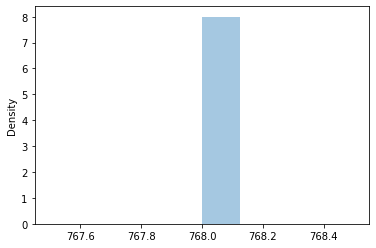

In [ ]:
doc_lengths = []

for i in range(len(finetune_clusters)):
    input_ids, attn_masks, loss_masks = train_dataset[i]

    # prompt_text = tokenizer.decode(input_ids)

    # get rough token count distribution
    # tokens = nltk.word_tokenize(prompt_text)

    doc_lengths.append(len(input_ids))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

**Validation dataset**

Go through the validation set query and match them with similar training examples. Obtain each data instance as prompt of that query alongwith examples from training set.

In [ ]:
val_dataset = GPT2Dataset(tokenizer, train = False, val_data = val_data, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, val_loss_masks = val_dataset[0]
tokenizer.decode(input_ids)

'<|startoftext|> Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp<|endoftext|> <|startoftext|> Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp<|endoftext|> <|startoftext|> Walk to bedroo

#### Dataloaders

In [ ]:
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

batch_size = 2

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

   66 training samples
1,016 validation samples


In [ ]:
next(iter(train_dataloader))[0].device

device(type='cuda', index=0)

**Fine-tuning GPT2**

### Model configuration

Reference [notebook](https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh#scrollTo=D6TKgyUzPIQc)

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

### Initialize parameters

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# some parameters I cooked up that work reasonably well

epochs = 20
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 20

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
!nvidia-smi

Wed Nov 23 22:15:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   2140MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
for p in model.parameters(): p.requires_grad_(False)
# only turn on linear probing for the LM head.
for p in model.lm_head.parameters(): p.requires_grad_(True)

### **Training**

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

accumulation_steps = 2

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
        model.zero_grad()

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        b_labels[b_loss_masks==0] = -100


        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        
        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss
    
        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # tokenizer("<|startoftext|> Walk to bedroom=>", return_tensors='pt')['input_ids'].cuda(),
                                    bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                                    eos_token_id = tokenizer.eos_token_id,
                                    pad_token_id = tokenizer.pad_token_id,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    continue
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        b_labels[b_loss_masks==0] = -100
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...


RuntimeError: ignored

In [ ]:
# Copy of above cell to preserve output

total_t0 = time.time()

training_stats = []

model = model.to(device)

accumulation_steps = 2

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
        model.zero_grad()

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        b_labels[b_loss_masks==0] = -100


        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        
        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss
    
        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    tokenizer("<|startoftext|> Walk to bedroom=>", return_tensors='pt')['input_ids'].cuda(),
                                    bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                                    eos_token_id = tokenizer.eos_token_id,
                                    pad_token_id = tokenizer.pad_token_id,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    continue
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        b_labels[b_loss_masks==0] = -100
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...


RuntimeError: ignored

In [ ]:
device

device(type='cuda')

In [ ]:
val_data[0]

'Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp=>Walk to bed=>Lie on bed=>Sleep=>Sleep=>Sleep\n'

In [ ]:
tokenizer("<|startoftext|> Walk to bedroom=>Walk to floor", return_tensors='pt')['input_ids'].cuda()

tensor([[50257,  6857,   284, 14043, 14804, 35963,   284,  4314]],
       device='cuda:0')

italicised text### **Validation**

In [ ]:
model.eval()

sample_outputs = model.generate(
                        tokenizer("<|startoftext|> Walk to bedroom=>Walk to floor", return_tensors='pt')['input_ids'].cuda(),
                        bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                        eos_token_id = tokenizer.eos_token_id,
                        pad_token_id = tokenizer.pad_token_id,
                        do_sample=True,   
                        # top_k=50, 
                        max_length = 200,
                        # top_p=0.95, 
                        num_return_sequences=1
                    )

In [ ]:
tokenizer.decode(sample_outputs[0])

'<|startoftext|>  Walk to bedroom=>Walk to floor <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
outputs['logits'].shape

loss = torch.nn.CrossEntropyLoss()
predicted_logits = outputs['logits']

In [ ]:
b_labels[b_loss_masks == 0] = -100

tensor([50257, 35963,   284,  1363,  2607, 14804, 35963,   284,  3072, 14804,
        16742,  3072, 14804, 48400,  3072, 50256, 50257, 35963,   284,  1363,
         2607, 14804, 35963,   284,  3072, 14804, 16742,  3072, 14804, 48400,
         3072, 50256], device='cuda:0')

In [ ]:
loss = torch.nn.NLLLoss()
predicted_logits = outputs['logits']


torch.Size([2, 768, 50259])

In [ ]:
model(input_ids, attention_mask = att)

NameError: ignored

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
preds = []
trues = []

for index in tqdm.tqdm(range(len(val_data)), total = len(val_data)):
  if index == 1: break # index = 0
  separator = '=>'
  splits = val_data[index].split(separator)
  
  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  for time_step in range(1, len(splits)-1):
    query = separator.join([text for text in splits[:time_step]])

    support_set = generate_training_set(query)

    for example in support_set:
      example = '<|startoftext|>' + example + '<|endoftext|>'

    prompt = f'''
    
    {''.join(support_set)}

    Now use the above data to predict what the robot might do next.
    {separator.join([text for text in splits[:time_step]])}=>'''

    result = raw_predict(prompt)
    pred = result.strip().split('\n')[0].split('=>')[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    time.sleep(4)

SyntaxError: ignored

## GPT-3 output sequences finetuning

**Unsupervised selection of few-shot examples**

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(train_data)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering() #n_clusters = None, affinity = 'cosine', linkage = 'average', distance_threshold = 0.4)
clustering.fit(embeddings)

AgglomerativeClustering()

In [ ]:
labels = clustering.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
fewshot_indices = []
for label in np.unique(labels):
    indices = np.random.choice(train_data[labels==label].index.tolist(), size = 15)
    fewshot_indices.extend(indices)
fewshot_indices

[74,
 114,
 398,
 437,
 326,
 117,
 254,
 160,
 452,
 402,
 410,
 396,
 145,
 457,
 340,
 161,
 97,
 445,
 31,
 142,
 81,
 181,
 376,
 387,
 230,
 291,
 291,
 390,
 372,
 156]

**Few shot learning from GPT-3**

In [ ]:
from prompting import predict_ns, raw_predict

In [ ]:
prompt = 'Tell me what you know about Epic Kitchens dataset'

In [ ]:
raw_predict(prompt)

'\n\nEpic Kitchens is a large-scale video dataset of cooking activities, annotated with action labels and object tracks. The dataset contains 100 hours of cooking videos from 30 different kitchens, captured with four synchronized cameras.'

In [ ]:
val_data[0]

'take plate=>put down plate=>take pizza=>put pizza onto plate=>take pizza=>put pizza slice onto plate=>take pizza slice=>put pizza slice onto plate=>take paper=>fold paper=>take paper=>open bin=>throw paper into bin=>close bin=>take tray=>take spatula=>put down tray=>take trays=>put down trays=>put down spatula and pizza cutter=>dry hands=>take plate=>put down plate=>take tablecloth=>fold tablecloth=>put tablecloth into cupboard=>take container=>open container=>take pizza slice=>put pizza slice into container=>take pizza slice=>take knife=>put down knife=>cut pizza=>put pizza slice into container=>put down knife=>take lid=>put down lid=>close container=>turn on tap=>wash hand=>turn off tap=>take sponge=>squeeze sponge=>take washing up liquid=>put down washing up liquid=>wash knife=>take fork=>wash fork=>put down fork=>take pizza cutter=>turn on tap=>rinse pizza cutter=>wash pizza cutter=>put down pizza cutter=>take plate=>wash plate=>put down plate=>take spatula=>wash spatula=>put down

In [ ]:
for i in val_data:
    print(len(i.split('=>')))

148
62
30
354
291
371
14
14
50
13
26
125
136
16
4
64
27
3
11
25
61
50
113
7
21
111
66
60
23
30
63
32
43
15
43
17
29
26
14
147
63
43
133
120
120
17
27
235
147
18
34
195
11
73
21
24
111
26
49
10
48
13
33
37
14
64
57
27
43
27
113
38
135
91
53
19
42
46
98
34
13
30
126
70
26
60
350
217
484
179
104
347
34
41
22
3
18
15
5
12
34
39
12
9
10
15
24
64
32
57
16
26
20
25
14
26
6
16
133
31
564
45
106
331
170
46
29
22
60
27
12
40
37
48
3
16
39
44


In [ ]:
index = 0
separator = '=>'
splits = val_data[index].split(separator)
time_step = np.random.randint(1, 15)#len(splits)-1)
prompt = f'''The following denotes a sequence of cooking activities from the Epic Kitchens dataset. Complete the remaining sequence.

{separator.join([text for text in splits[:time_step]])}=>'''
# {'. '.join(['I ' + text for text in splits[:time_step]])}. Then I '''
print(prompt)

The following denotes a sequence of cooking activities from the Epic Kitchens dataset. Complete the remaining sequence.

take plate=>put down plate=>take pizza=>put pizza onto plate=>take pizza=>put pizza slice onto plate=>take pizza slice=>put pizza slice onto plate=>take paper=>fold paper=>take paper=>


In [ ]:
time_step, splits[time_step]

(11, 'open bin')

In [ ]:
raw_predict(prompt)

'fold paper=>\n\ntake paper=>fold paper=>take paper=>fold paper=>take paper=>fold paper=>take paper=>fold paper=>take paper=>fold paper=>take paper=>fold paper'

**Dataset 2:** Virtual Homes

**Zero-shot GPT-3 learning**

In [ ]:
train_data = pd.Series(open('virtual_home_train_prompt.txt').readlines())
val_data = pd.Series(open('virtual_home_validation_prompt.txt').readlines())
test_data = pd.Series(open('virtual_home_test_prompt.txt').readlines())

Support set i

In [ ]:
train_data

0       Walk to home office=>Walk to computer=>Find co...
1       Find clothes dress=>Find towel=>Walk to bathro...
2       Find remote control=>Grab remote control=>Find...
3       Walk to home office=>Walk to clothes jacket=>F...
4       Walk to bathroom=>Walk to basket for clothes=>...
                              ...                        
3047    Walk to home office=>Walk to filing cabinet=>O...
3048    Walk to home office=>Walk to phone=>Find phone...
3049    Walk to dining room=>Walk to table=>Find table...
3050    Walk to dining room=>Walk to food food=>Find f...
3051    Walk to home office=>Walk to table=>Find table...
Length: 3052, dtype: object

In [ ]:
val_data

0       Walk to bedroom=>Walk to floor lamp=>Switch of...
1       Walk to home office=>Walk to purse=>Find purse...
2       Walk to dining room=>Walk to clothes dress=>Fi...
3                                   Find cat=>Touch cat\n
4       Walk to home office=>Walk to couch=>Find couch...
                              ...                        
1011    Find television=>Turn to television=>Look at t...
1012    Walk to home office=>Walk to light=>Find light...
1013    Walk to home office=>Walk to television=>Plug ...
1014    Walk to home office=>Walk to laptop=>Find lapt...
1015    Find cup=>Turn to cup=>Point at cup=>Grab cup=...
Length: 1016, dtype: object

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForCausalLM

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B", cache_dir = './gpt2_tok')
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B", cache_dir = './gpt_neo')

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

In [ ]:
prompt = "a,b,c,d,e,f"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits

greedy_output = model.generate(input_ids = inputs["input_ids"], max_length=256)

print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

**GPT-Neo finetuning**

In [ ]:
query = val_data[0]
query_instruct_text

In [ ]:
task = 

In [ ]:
train_data

['open door turn on light close door open fridge take celery take container take tofu close fridge open fridge take carrots and open drawer close fridge put down vegetables open cupboard take cutting board put down cutting board close cupboard open drawer take knife take knife put down knife close drawer put down knife open tap wash courgette still washing courgette wash carrot still washing carrot close tap put down vegetables open cupboard take grater take pan put down pan close cupboard close cupboard take courgette cut courgette turn on hob cut courgette still cutting courgette dicing courgette still dicing courgette still dicing courgette still dicing courgette pour courgette onto pan throw courgette into rubbish bin open drawer close drawer take spatula stir courgette take salt open salt pour salt onto pan put down salt stir courgette put down spatula take celery still washing celery open tap wash celery close tap put down celery cut celery still cutting celery pour celery onto p